In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [119]:
data_path = '../../data/postprocessed/stress/'

mapping_table = {
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

../../data/postprocessed/stress/NN50PercLeNet5_1.csv
../../data/postprocessed/stress/gpuburn5min_1.csv
../../data/postprocessed/stress/NN50Percresnet18_1.csv
../../data/postprocessed/stress/NN50Percmnasnet05_1.csv
../../data/postprocessed/stress/NN50Percmobilenetv2_1.csv


## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [120]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 155840


### Apparently not

### Thus, it must be dependent only on the application complexity

In [121]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: LeNet5
Instances: 49984
--------------------------------------------------------------------
App name: MnasNet
Instances: 31488
--------------------------------------------------------------------
App name: MobileNetV2
Instances: 42240
--------------------------------------------------------------------
App name: ResNet18
Instances: 30048
--------------------------------------------------------------------
App name: GPU-burn
Instances: 2080


### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

In [123]:
data_sheet['rollup_operation'].unique()
# It is a useless column, we can drop it
# data_sheet = data_sheet.drop('rollup_operation', axis=1)

array(['avg', 'sum', 'pct'], dtype=object)

### Available data

In [124]:
location_mapping={
    'sm': 'Streaming Multiprocessor',
    'dram': 'Dynamic RAM',
    'l1tex': 'L1 Cache',
    'lts': 'L2 Cache',
    'smsp': 'Streaming Multiprocessor SubPartition'
}
data_sheet['location'].unique()

array(['sm', 'dram', 'l1tex', 'lts', 'smsp'], dtype=object)

In [125]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
# data_sheet.drop('location', axis=1, inplace=True)

In [126]:
metric_event_mapping= {

    # Workload
    ## Compute
    'request_cycles_active': 'Number of cycles where the IDC processed requests from SM',
    'instruction_throughput': 'Instruction throughput',
    'inst_executed': 'Executed instructions',
    'inst_issued': 'Issued instructions',
    'sass_thread_inst_executed_op_fp64_pred_on': 'Instructions FP64',
    'sass_thread_inst_executed_op_integer_pred_on': 'Instructions Integers',

    ## Memory
    ### DRAM
    'bytes_read': 'Read Bytes',
    'bytes_write': 'Written bytes',

    ### L1 Cache
    't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit': 'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st_lookup_hit': 'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red_lookup_hit': 'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit': 'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_ld': ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st': ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red': 'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom': 'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
    
    ### L2 Cache
    't_sector_op_read_hit_rate': 'L2 hit rate by read instruction',
    't_sector_op_write_hit_rate': 'L2 hit rate by write instruction',

    # Stall
    ## Memory
    'warp_issue_stalled_imc_miss_per_warp_active': 'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
    'warp_issue_stalled_long_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',

    ## Controller
    'warp_issue_stalled_short_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
    'warp_issue_stalled_wait_per_warp_active': 'Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp',
    'warp_issue_stalled_not_selected_per_warp_active': 'Warp Issue Stalls Due to Not Being Selected per Active Warp',
    'warp_issue_stalled_sleeping_per_warp_active': 'Warp Issue Stalls Due to Sleeping per Active Warp',
    'warp_issue_stalled_membar_per_warp_active': 'Warp Issue Stalls Due to Membar per Active Warp',
    'warp_issue_stalled_barrier_per_warp_active': 'Warp Issue Stalls Due to Barrier per Active Warp',
    'warp_issue_stalled_dispatch_stall_per_warp_active': 'Warp Issue Stalls Due to Dispatch Stall per Active Warp',

    ## Throttle
    'warp_issue_stalled_drain_per_warp_active': 'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
    'warp_issue_stalled_lg_throttle_per_warp_active': 'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
    'warp_issue_stalled_math_pipe_throttle_per_warp_active': 'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
    'warp_issue_stalled_mio_throttle_per_warp_active': 'Warp Issue Stalls Due to MIO Throttling per Active Warp',
    'warp_issue_stalled_tex_throttle_per_warp_active': 'Warp Issue Stalls Due to Texture Throttling per Active Warp',

    ## Others
    'warp_issue_stalled_misc_per_warp_active': 'Warp Issue Stalls Due to Miscellaneous Issues per Active Warp',

}
data_sheet['metric_name'].unique()

array(['inst_executed', 'instruction_throughput', 'inst_issued',
       'bytes_read', 'bytes_write',
       't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_st_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_red_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit',
       't_sectors_pipe_lsu_mem_global_op_ld',
       't_sectors_pipe_lsu_mem_global_op_st',
       't_sectors_pipe_lsu_mem_global_op_red',
       't_sectors_pipe_lsu_mem_global_op_atom',
       't_sector_op_read_hit_rate', 't_sector_op_write_hit_rate',
       'sass_thread_inst_executed_op_fp64_pred_on',
       'sass_thread_inst_executed_op_integer_pred_on',
       'warp_issue_stalled_short_scoreboard_per_warp_active',
       'warp_issue_stalled_imc_miss_per_warp_active',
       'warp_issue_stalled_long_scoreboard_per_warp_active',
       'warp_issue_stalled_wait_per_warp_active',
       'warp_issue_stalled_not_selected_per_warp_active',
       'warp_issue_stal

In [127]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
data_sheet['HR_metrics'] = data_sheet['HR_metric_name'] + '('+ data_sheet['rollup_operation'] +')' + data_sheet['Post'] 
# data_sheet.drop('metric_name', axis=1, inplace=True)

In [128]:
data_sheet['HR_metric_name'].unique()

array(['Executed instructions', 'Instruction throughput',
       'Issued instructions', 'Read Bytes', 'Written bytes',
       'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
       'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
       'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
       'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
       ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
       ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
       'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
       'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
       'L2 hit rate by read instruction',
       'L2 hit rate by write instruction', 'Instructions FP64',
       'Instructions Integers',
       'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
       'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
       

### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [129]:
data_sheet['Range'].dtypes

dtype('int64')

In [130]:
data_sheet_1 = data_sheet[data_sheet['Range']==1]

### Regardless of the application I want to see the correlation within the columns

In [131]:
data_sheet[data_sheet['HR_location']=='L1 Cache'].columns

Index(['session_id', 'duration_ms', 'location', 'metric_name',
       'rollup_operation', 'Post', 'range_name', 'metric_value', 'Range',
       'App_name', 'progress', 'HR_location', 'HR_metric_name', 'HR_metrics'],
      dtype='object')

In [132]:
df_l2 = data_sheet[data_sheet['HR_location']=='L2 Cache']
df_sm = data_sheet[data_sheet['HR_location']=='Streaming Multiprocessor']
df_smsp = data_sheet[data_sheet['HR_location']=='Streaming Multiprocessor SubPartition']
df_l1 = data_sheet[data_sheet['HR_location']=='L1 Cache']
df_dram = data_sheet[data_sheet['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2, 
    'Streaming Multiprocessor': df_sm, 
    'Streaming Multiprocessor SubPartition': df_smsp, 
    'L1 Cache': df_l1, 
    'Dynamic RAM': df_dram
    }

In [175]:
df_pivot_l2 = df_l2.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp = df_smsp.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp['Memory Stall']=(df_pivot_smsp['Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp '] +\
              df_pivot_smsp['Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp']) /2

df_pivot_smsp['Controller Stall']=(df_pivot_smsp['Warp Issue Stalls Due to Not Being Selected per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Sleeping per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Membar per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Barrier per Active Warp'] ) /7

df_pivot_smsp['Throttle Stall']=(df_pivot_smsp['Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Math Pipe Throttling per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to MIO Throttling per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Texture Throttling per Active Warp']) /5

df_pivot_l1 = df_l1.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_l1['Global hit rate'] = (df_pivot_l1['Global Memory Atomic – Cache Hit (per Thread Set via LSU)']+ \
                                df_pivot_l1['Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1['Global Memory Reduction – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1['Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)']) / \
                                (df_pivot_l1[' Global Memory Load Sectors Served by L1 Cache (via LSU)']+ \
                                df_pivot_l1[' Global Memory Store Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1['Global Memory Atomic Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1['Global Memory Reduction Sectors Served by L1 Cache (via LSU)'])

df_pivot_dram = df_dram.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2, 
    'Streaming Multiprocessor': df_pivot_sm, 
    'Streaming Multiprocessor SubPartition': df_pivot_smsp, 
    'L1 Cache': df_pivot_l1, 
    'Dynamic RAM': df_pivot_dram
    }

In [176]:
pivot_dfs['Streaming Multiprocessor SubPartition'].columns

Index(['progress', 'HR_location', 'range_name', 'Range', 'App_name',
       'rollup_operation', 'Post', 'Instructions FP64',
       'Instructions Integers',
       'Warp Issue Stalls Due to Barrier per Active Warp',
       'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
       'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
       'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
       'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',
       'Warp Issue Stalls Due to MIO Throttling per Active Warp',
       'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
       'Warp Issue Stalls Due to Membar per Active Warp',
       'Warp Issue Stalls Due to Not Being Selected per Active Warp',
       'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
       'Warp Issue Stalls Due to Sleeping per Active Warp',
     

In [160]:
a = pivot_dfs['L1 Cache'].groupby(by=["App_name"])[['Global hit rate']]\
    .mean()\
        .reset_index()

b = pivot_dfs['L2 Cache'].groupby(by=["App_name"])[[ 'L2 hit rate by read instruction','L2 hit rate by write instruction']]\
    .mean()\
        .reset_index()

c = pivot_dfs['Streaming Multiprocessor'].groupby(by=["App_name"])[[ 'Executed instructions','Instruction throughput', 'Issued instructions']]\
    .mean()\
        .reset_index()

d = pivot_dfs['Dynamic RAM'].groupby(by=["App_name"])[[ 'Read Bytes', 'Written bytes']]\
    .mean()\
        .reset_index()

e = pivot_dfs['Streaming Multiprocessor SubPartition'].groupby(by=["App_name"])[['Memory Stall', 'Controller Stall', 'Throttle Stall']]\
    .mean()\
        .reset_index()
# for location in list(pivot_dfs.keys()):
    

In [161]:
c

HR_metric_name,App_name,Executed instructions,Instruction throughput,Issued instructions
0,GPU-burn,2.990453,74.817254,38.904972
1,LeNet5,1.183488,32.217649,16.746315
2,MnasNet,1.061648,27.617759,13.934777
3,MobileNetV2,1.130810,29.915203,14.958535
4,ResNet18,1.225137,31.191437,16.198995


In [162]:
merge_1 = pd.merge(a, b[['App_name', 'L2 hit rate by read instruction','L2 hit rate by write instruction']], on='App_name')
merge_2 = pd.merge(merge_1, c[['App_name', 'Executed instructions','Instruction throughput', 'Issued instructions']], on='App_name')
merge_3 = pd.merge(merge_2, d[['App_name','Read Bytes', 'Written bytes']], on='App_name')
final_merge = pd.merge(merge_3, e[['App_name', 'Memory Stall', 'Controller Stall', 'Throttle Stall']], on='App_name')

In [163]:
final_merge

HR_metric_name,App_name,Global hit rate,L2 hit rate by read instruction,L2 hit rate by write instruction,Executed instructions,Instruction throughput,Issued instructions,Read Bytes,Written bytes,Memory Stall,Controller Stall,Throttle Stall
0,GPU-burn,0.007292,93.405466,99.975651,2.990453,74.817254,38.904972,2.574743e+10,1.293163e+09,0.309792,8.571913,0.279913
1,LeNet5,0.311760,57.975237,97.792423,1.183488,32.217649,16.746315,5.259026e+10,4.700330e+10,26.568624,3.890223,1.906639
2,MnasNet,0.404591,23.283742,99.997708,1.061648,27.617759,13.934777,7.106233e+10,6.354929e+10,28.716730,3.014385,3.339615
3,MobileNetV2,0.402480,32.048738,99.997760,1.130810,29.915203,14.958535,7.288789e+10,6.378180e+10,27.693374,3.251044,3.317270
4,ResNet18,0.314547,29.337055,99.998067,1.225137,31.191437,16.198995,7.373824e+10,6.458450e+10,32.451515,3.838605,1.916114


<Axes: xlabel='Metric', ylabel='Value'>

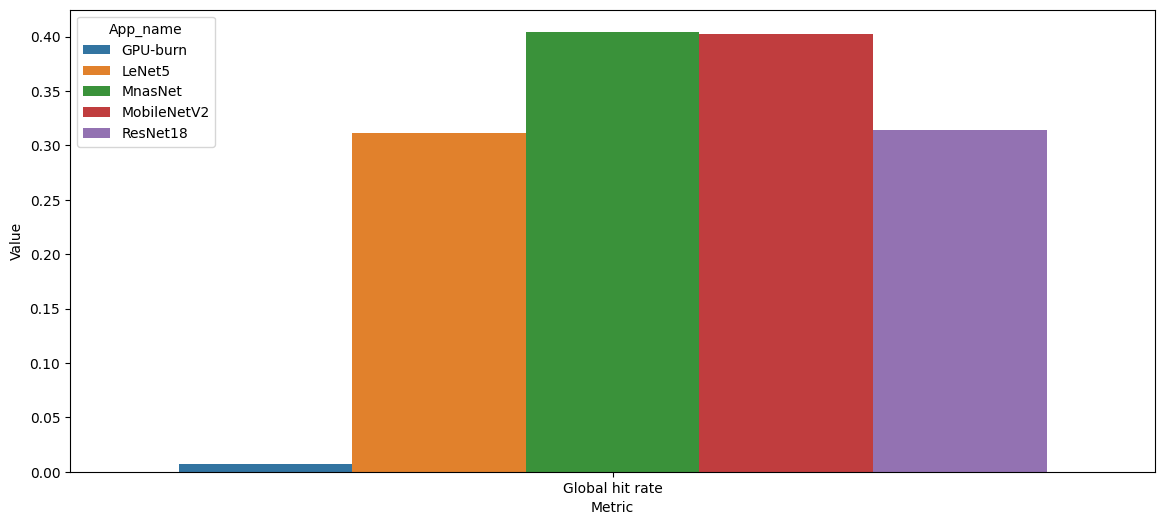

In [169]:
a_merge = pd.melt(
    a,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
# plt.yscale('log')
sns.barplot(data=a_merge, x='Metric', y='Value', hue='App_name')

<Axes: xlabel='Metric', ylabel='Value'>

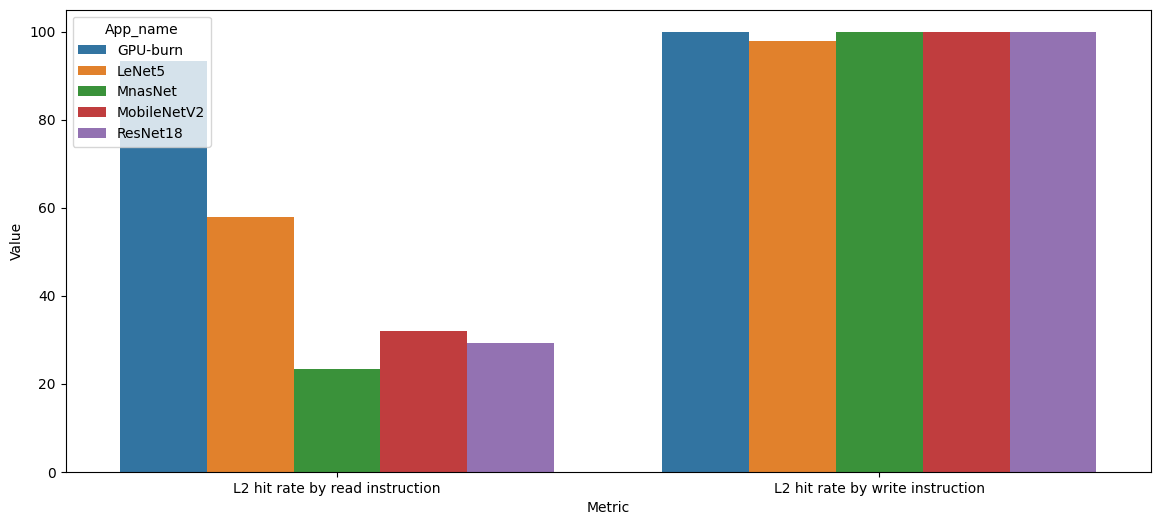

In [170]:
b_merge = pd.melt(
    b,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
# plt.yscale('log')
sns.barplot(data=b_merge, x='Metric', y='Value', hue='App_name')

<Axes: xlabel='Metric', ylabel='Value'>

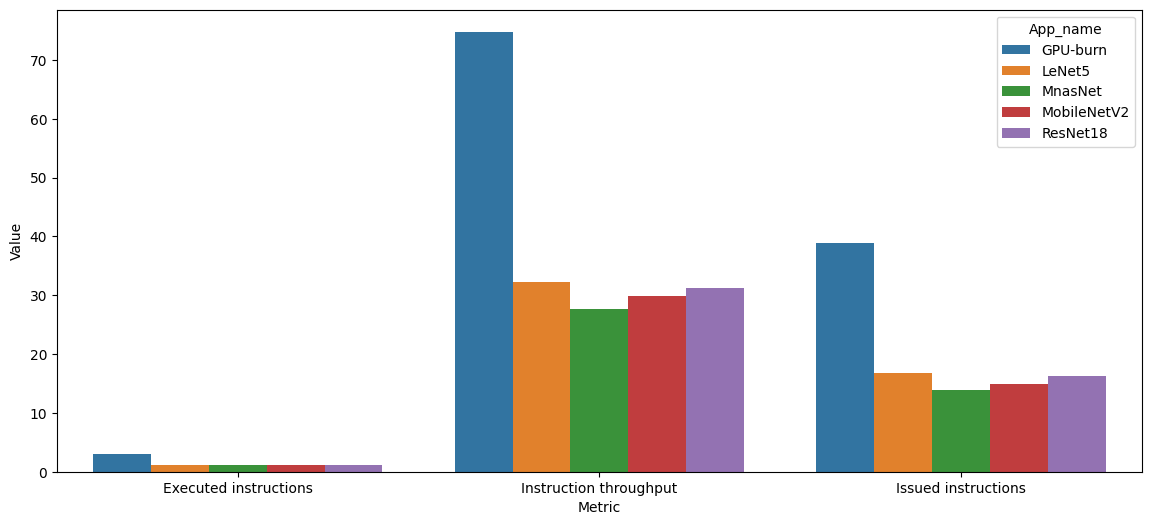

In [171]:
c_merge = pd.melt(
    c,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
# plt.yscale('log')
sns.barplot(data=c_merge, x='Metric', y='Value', hue='App_name')

<Axes: xlabel='Metric', ylabel='Value'>

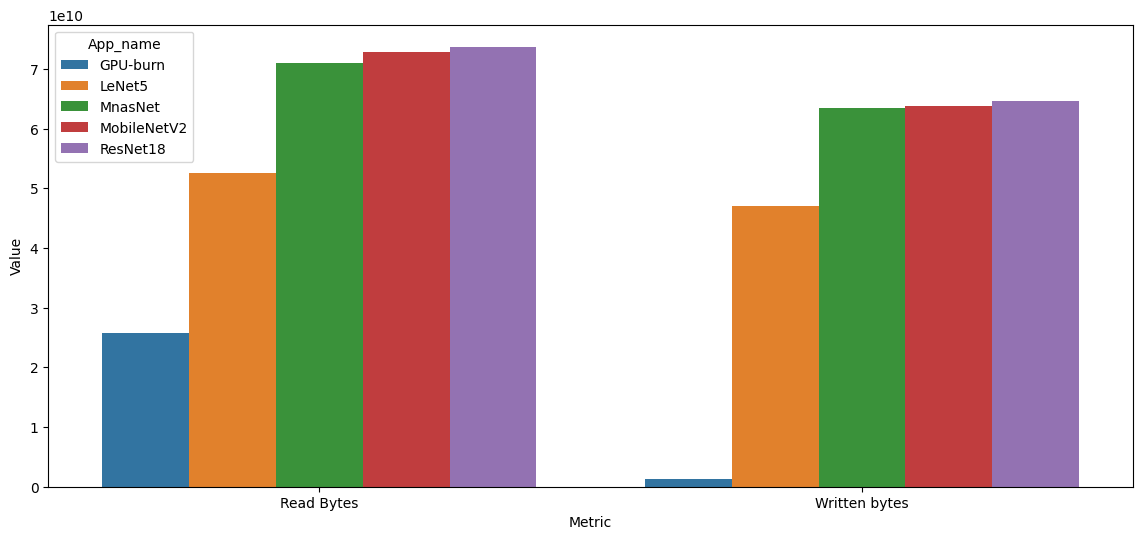

In [172]:
d_merge = pd.melt(
    d,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
# plt.yscale('log')
sns.barplot(data=d_merge, x='Metric', y='Value', hue='App_name')

<Axes: xlabel='Metric', ylabel='Value'>

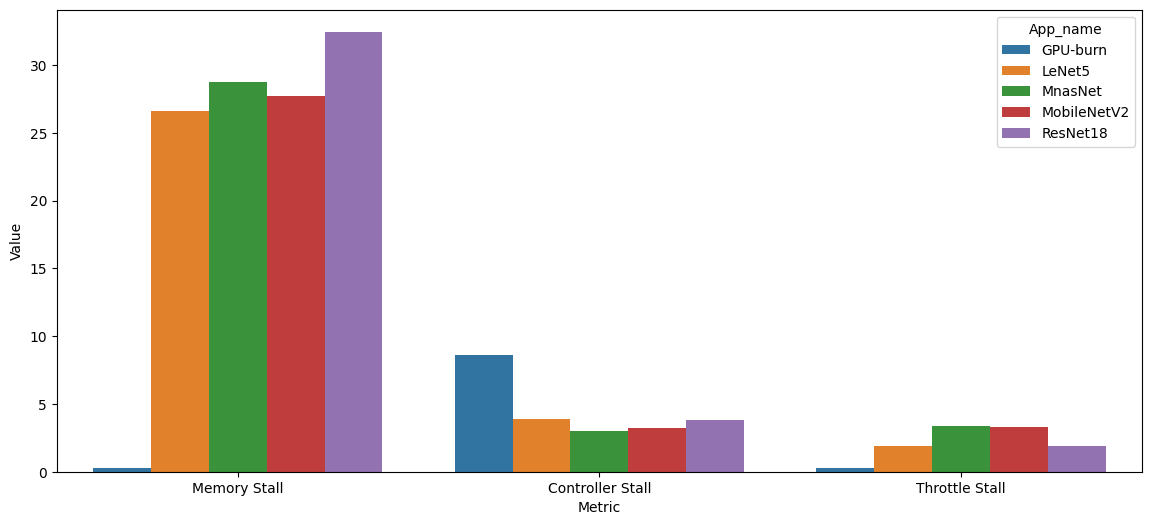

In [173]:
e_merge = pd.melt(
    e,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(14, 6))
# plt.yscale('log')
sns.barplot(data=e_merge, x='Metric', y='Value', hue='App_name')

In [177]:
a = pivot_dfs['L1 Cache'].groupby(by=["App_name", "progress"])[['Global hit rate']]\
    .mean()\
        .reset_index()

b = pivot_dfs['L2 Cache'].groupby(by=["App_name", "progress"])[[ 'L2 hit rate by read instruction','L2 hit rate by write instruction']]\
    .mean()\
        .reset_index()

c = pivot_dfs['Streaming Multiprocessor'].groupby(by=["App_name", "progress"])[[ 'Executed instructions','Instruction throughput', 'Issued instructions']]\
    .mean()\
        .reset_index()

d = pivot_dfs['Dynamic RAM'].groupby(by=["App_name", "progress"])[[ 'Read Bytes', 'Written bytes']]\
    .mean()\
        .reset_index()

e = pivot_dfs['Streaming Multiprocessor SubPartition'].groupby(by=["App_name", "progress"])[['Memory Stall', 'Controller Stall', 'Throttle Stall']]\
    .mean()\
        .reset_index()
# for location in list(pivot_dfs.keys()):
    

In [179]:
a.columns

Index(['App_name', 'progress', 'Global hit rate'], dtype='object', name='HR_metric_name')

<Axes: xlabel='progress', ylabel='Global hit rate'>

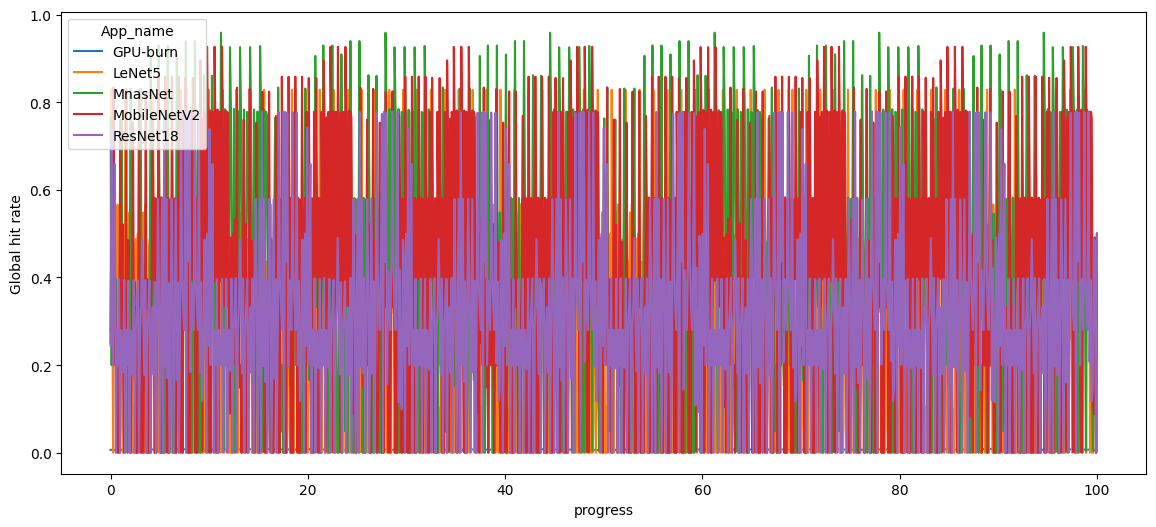

In [183]:
plt.figure(figsize=(14, 6))
# plt.yscale('log')
sns.lineplot(data=a, x='progress', y='Global hit rate', hue='App_name')

In [78]:
data_sheet['Post'].unique()

array(['per_cycle_elapsed', 'pct_of_peak_sustained_active',
       'per_cycle_active', 'per_second', 'No post'], dtype=object)

In [79]:
metric_full_name = data_sheet['HR_location'] +' '+ data_sheet['HR_metric_name'] + '('+ data_sheet['rollup_operation'] +')' + data_sheet['Post'] 
metric_full_name

0         Streaming Multiprocessor Executed instructions...
1         Streaming Multiprocessor Instruction throughpu...
2         Streaming Multiprocessor Executed instructions...
3         Streaming Multiprocessor Issued instructions(a...
4         Streaming Multiprocessor Issued instructions(a...
                                ...                        
155835    Streaming Multiprocessor SubPartition Warp Iss...
155836    Streaming Multiprocessor SubPartition Warp Iss...
155837    Streaming Multiprocessor SubPartition Warp Iss...
155838    Streaming Multiprocessor SubPartition Warp Iss...
155839    Streaming Multiprocessor SubPartition Warp Iss...
Length: 155840, dtype: object

### Stress evaluation

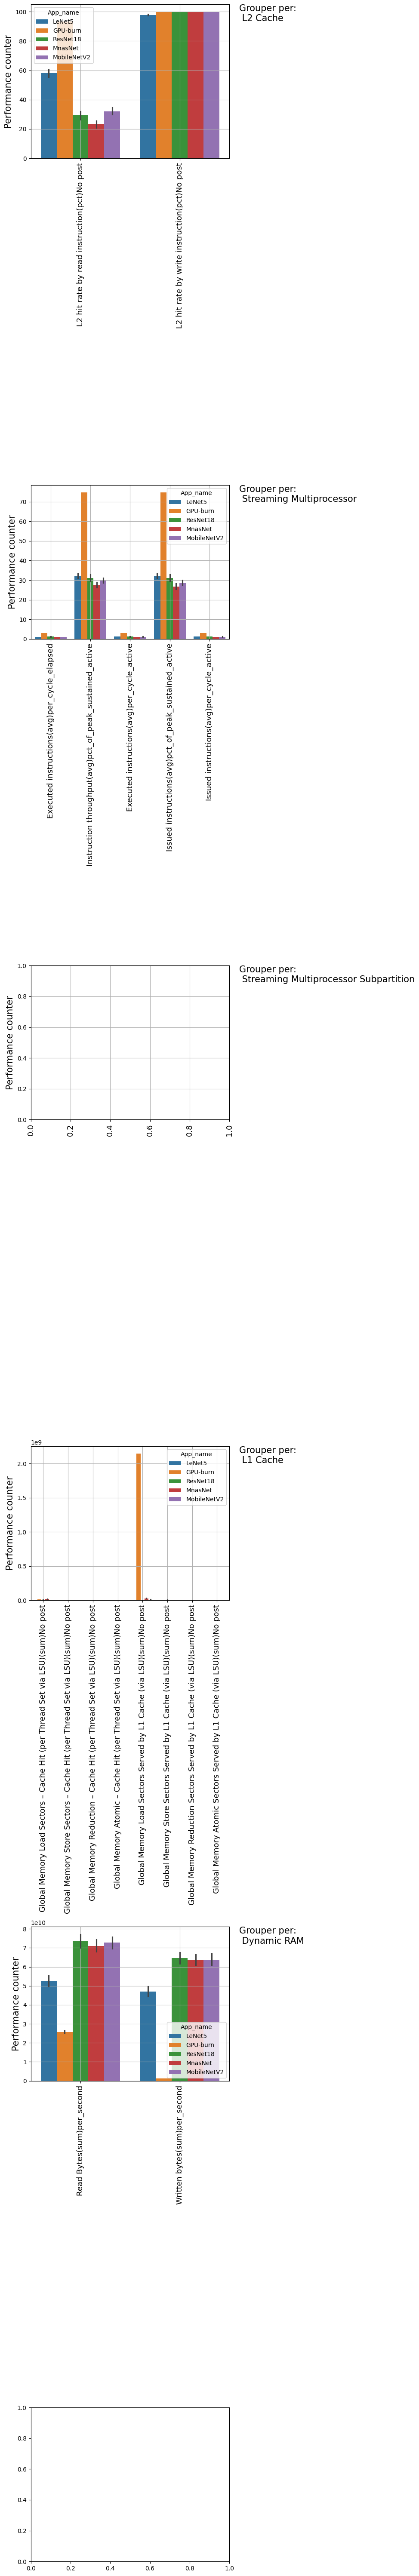

In [82]:
fig, ax = plt.subplots(6,1,figsize=(10,60))
for df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metrics', y='metric_value', hue='App_name', ax = ax[df_idx])
    # ax[df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[df_idx].text(1.05, 1.0, f'Grouper per: \n {HR_location}', transform=ax[df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[df_idx].grid()
    # ax[df_idx].set_yscale('log')
    ax[df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
    ax[df_idx].set_xlabel('')
plt.tight_layout()

/tmp/ipykernel_18118/2962318033.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data_gpu_burn, x='progress', y='metric_value', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_18118/2962318033.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data_gpu_burn, x='progress', y='metric_value', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_18118/2962318033.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data_gpu_burn, x='progress', y='metric_value', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_18118/2962318033.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data_gpu_burn, x='progress', y='metric_value', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_18118/2962318033.py:8: Fu

IndexError: index 30 is out of bounds for axis 0 with size 30

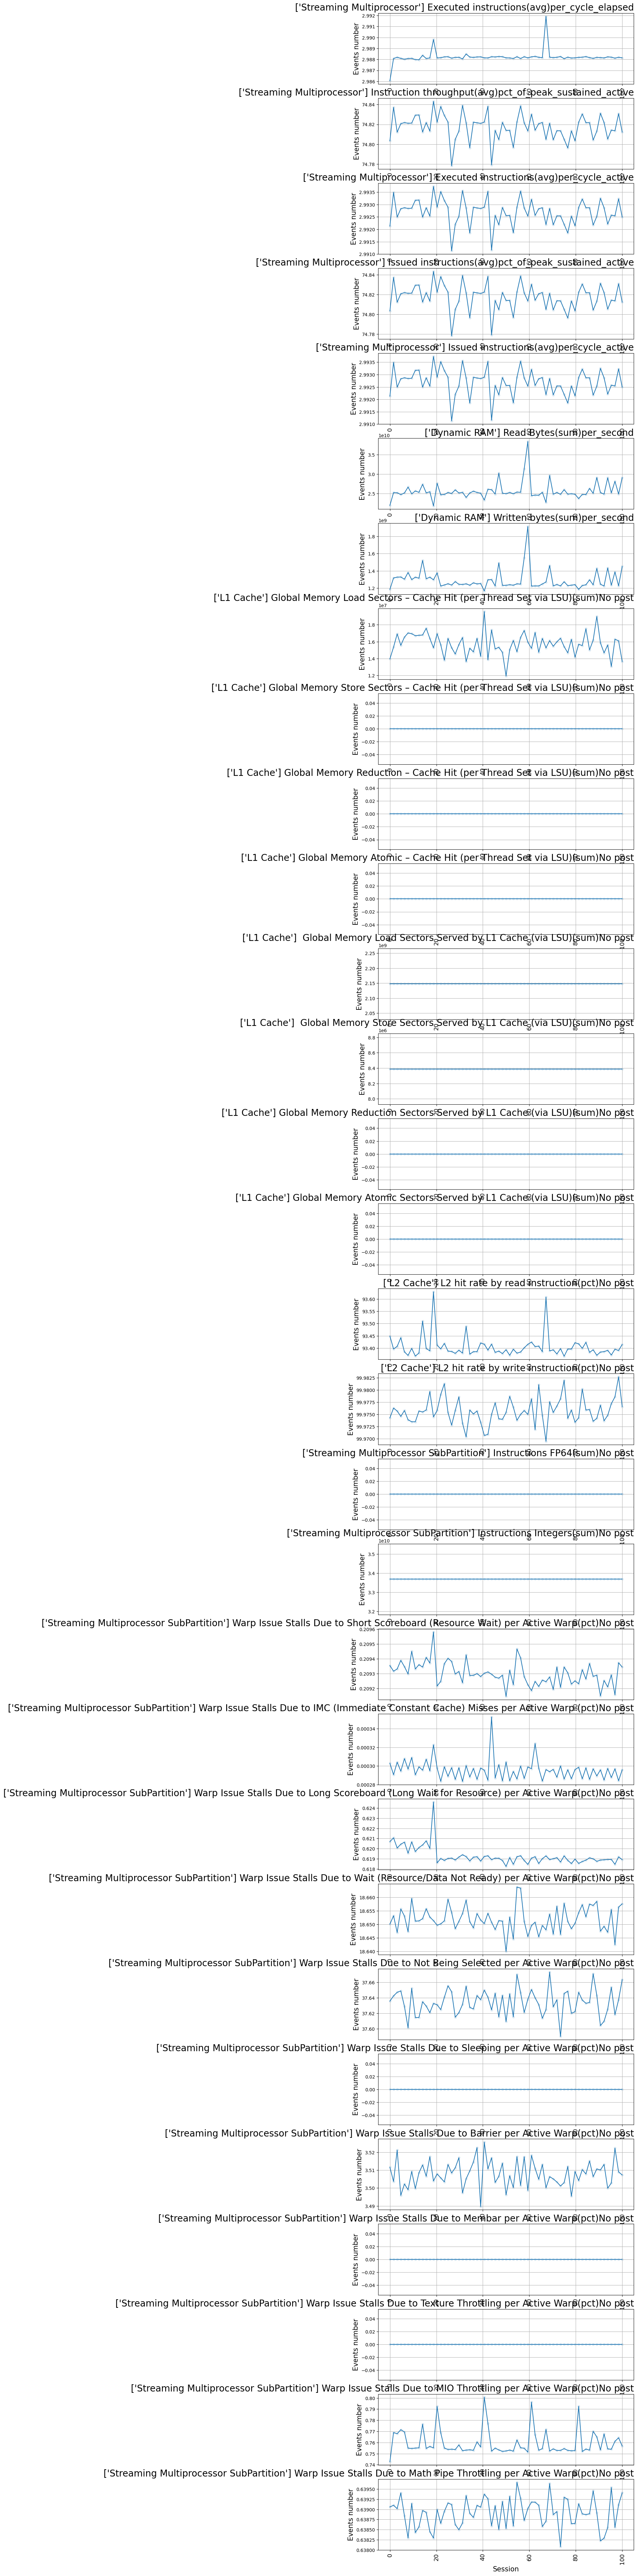

In [74]:
fig, ax = plt.subplots(30,1,figsize=(10,100))

for metric_idx in range(len(data_sheet['HR_metrics'].unique())):
    metric_name = data_sheet['HR_metrics'].unique()[metric_idx]
    data = data_sheet[data_sheet['HR_metrics'] == metric_name]
    data_gpu_burn = data[data['App_name'] == 'GPU-burn']
    HR_location=data['HR_location'].unique()
    sns.lineplot(data = data_gpu_burn, x='progress', y='metric_value', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data_gpu_burn, x='progress', y='metric_value', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

### Final remarks

### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 

### Metrics description
- SM Active cycles: Per ogni SM (in media) how many times there is at least an active warp?
- SM Active warps: Per ogni SM (in media) how many warps are active?